In [1]:
%matplotlib inline

In [2]:
%run notebook_setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

theano version: 1.0.4
pymc3 version: 3.6
exoplanet version: 0.1.5


In [3]:
# tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")
# tois.columns
# toi = tois[tois["TOI"] == 512.01].iloc[0]
# toi["Period (days)"], toi["Epoch (BJD)"], tois["Depth (ppm)"]

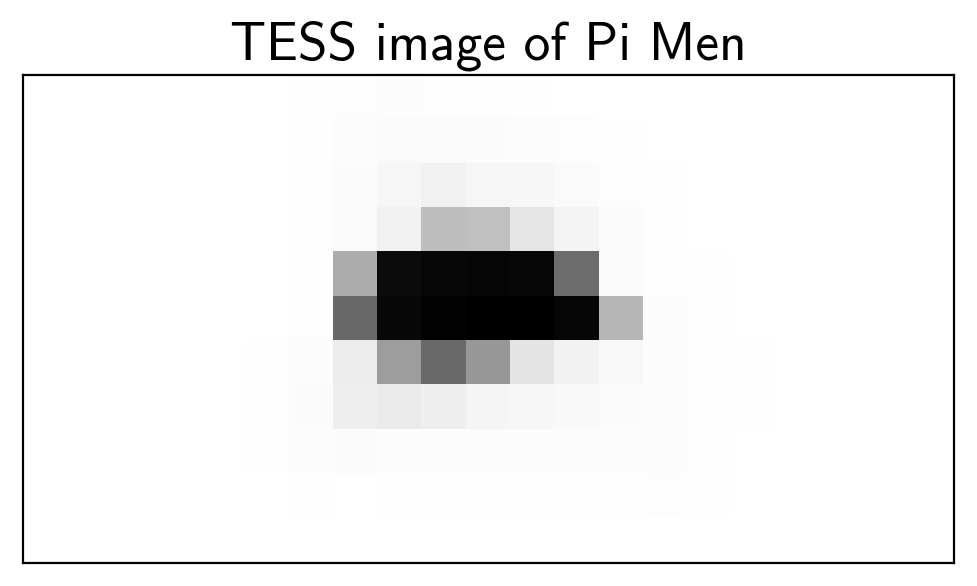

In [4]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

tpf_url = "https://archive.stsci.edu/missions/tess/tid/s0001/0000/0002/6113/6679/tess2018206045859-s0001-0000000261136679-0120-s_tp.fits"
with fits.open(tpf_url) as hdus:
    tpf = hdus[1].data
    tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

mean_img = np.median(flux, axis=0)
plt.imshow(mean_img.T, cmap="gray_r")
plt.title("TESS image of Pi Men")
plt.xticks([])
plt.yticks([]);

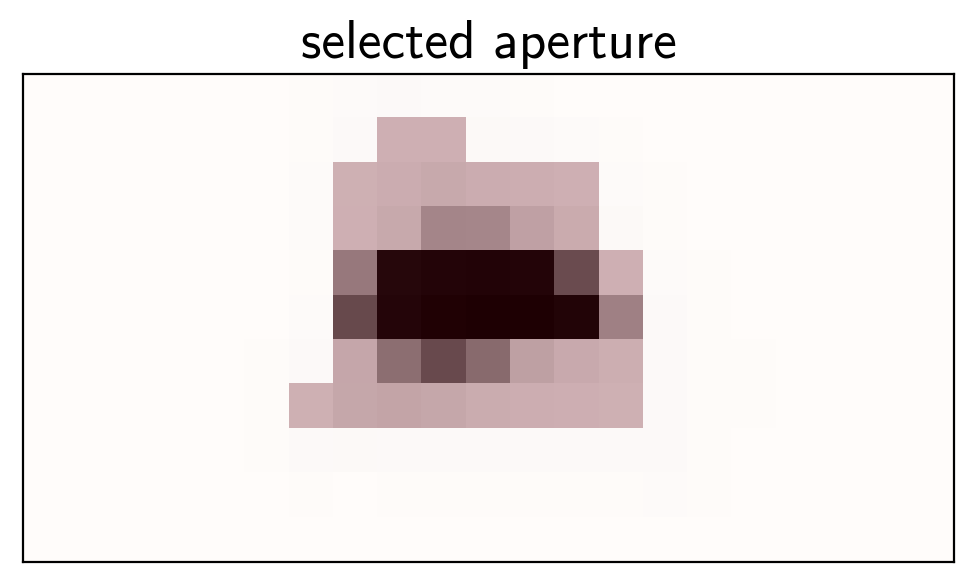

In [5]:
from scipy.signal import savgol_filter

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(10, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

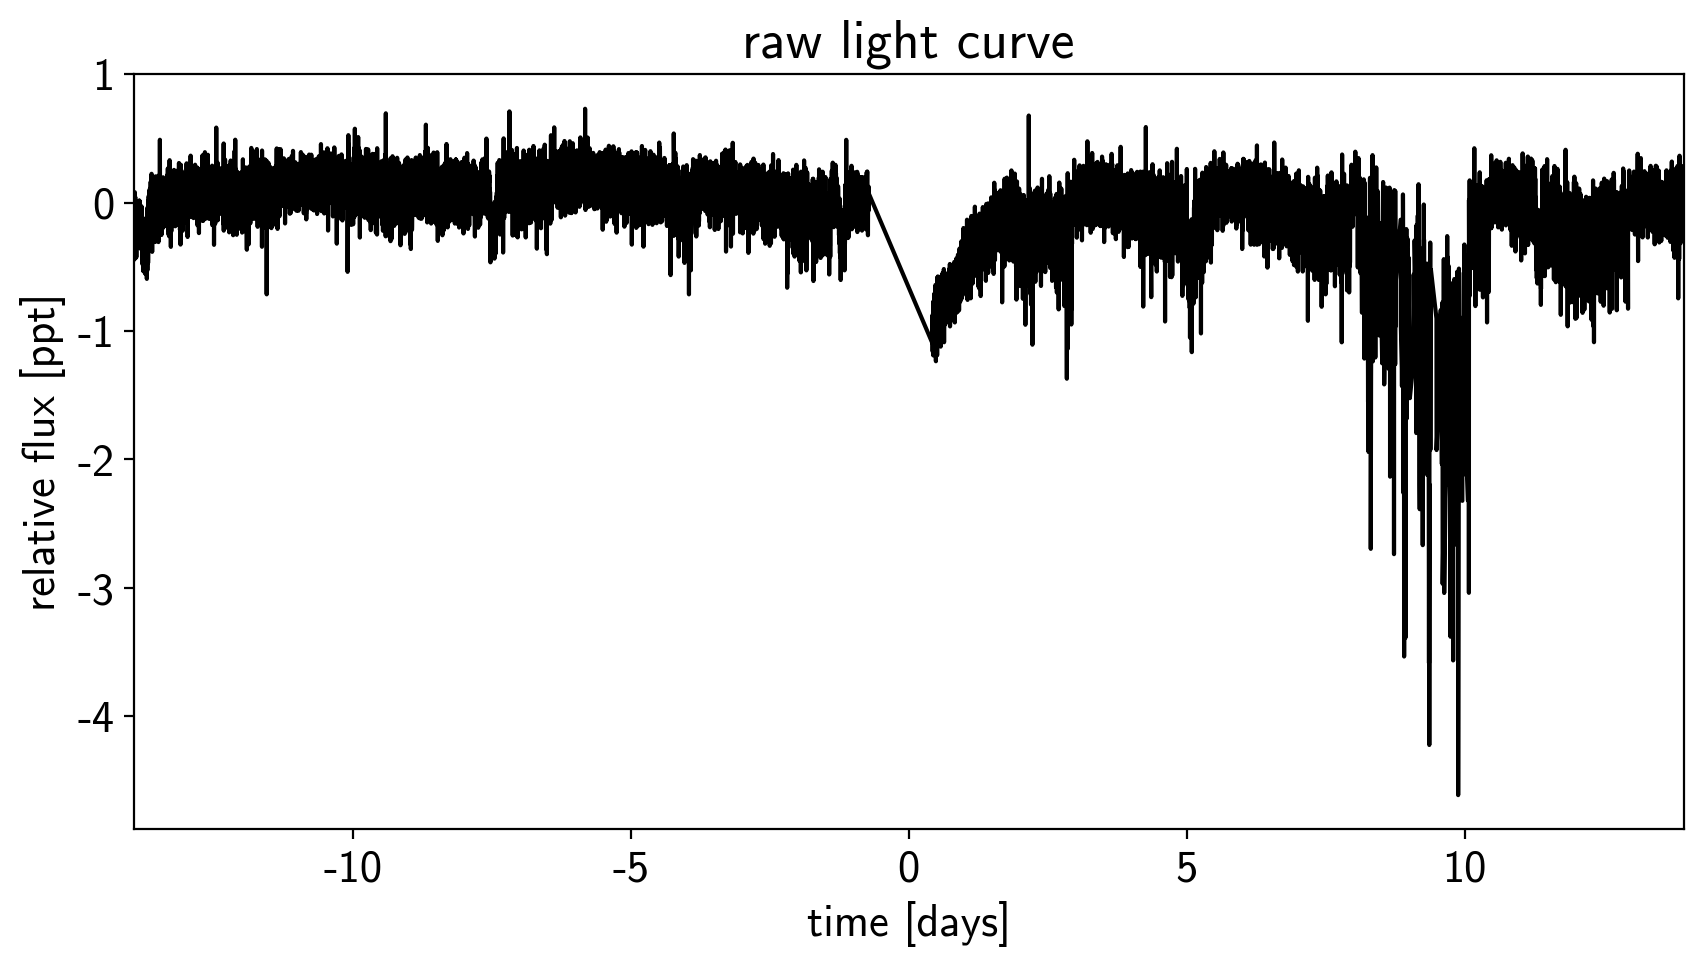

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

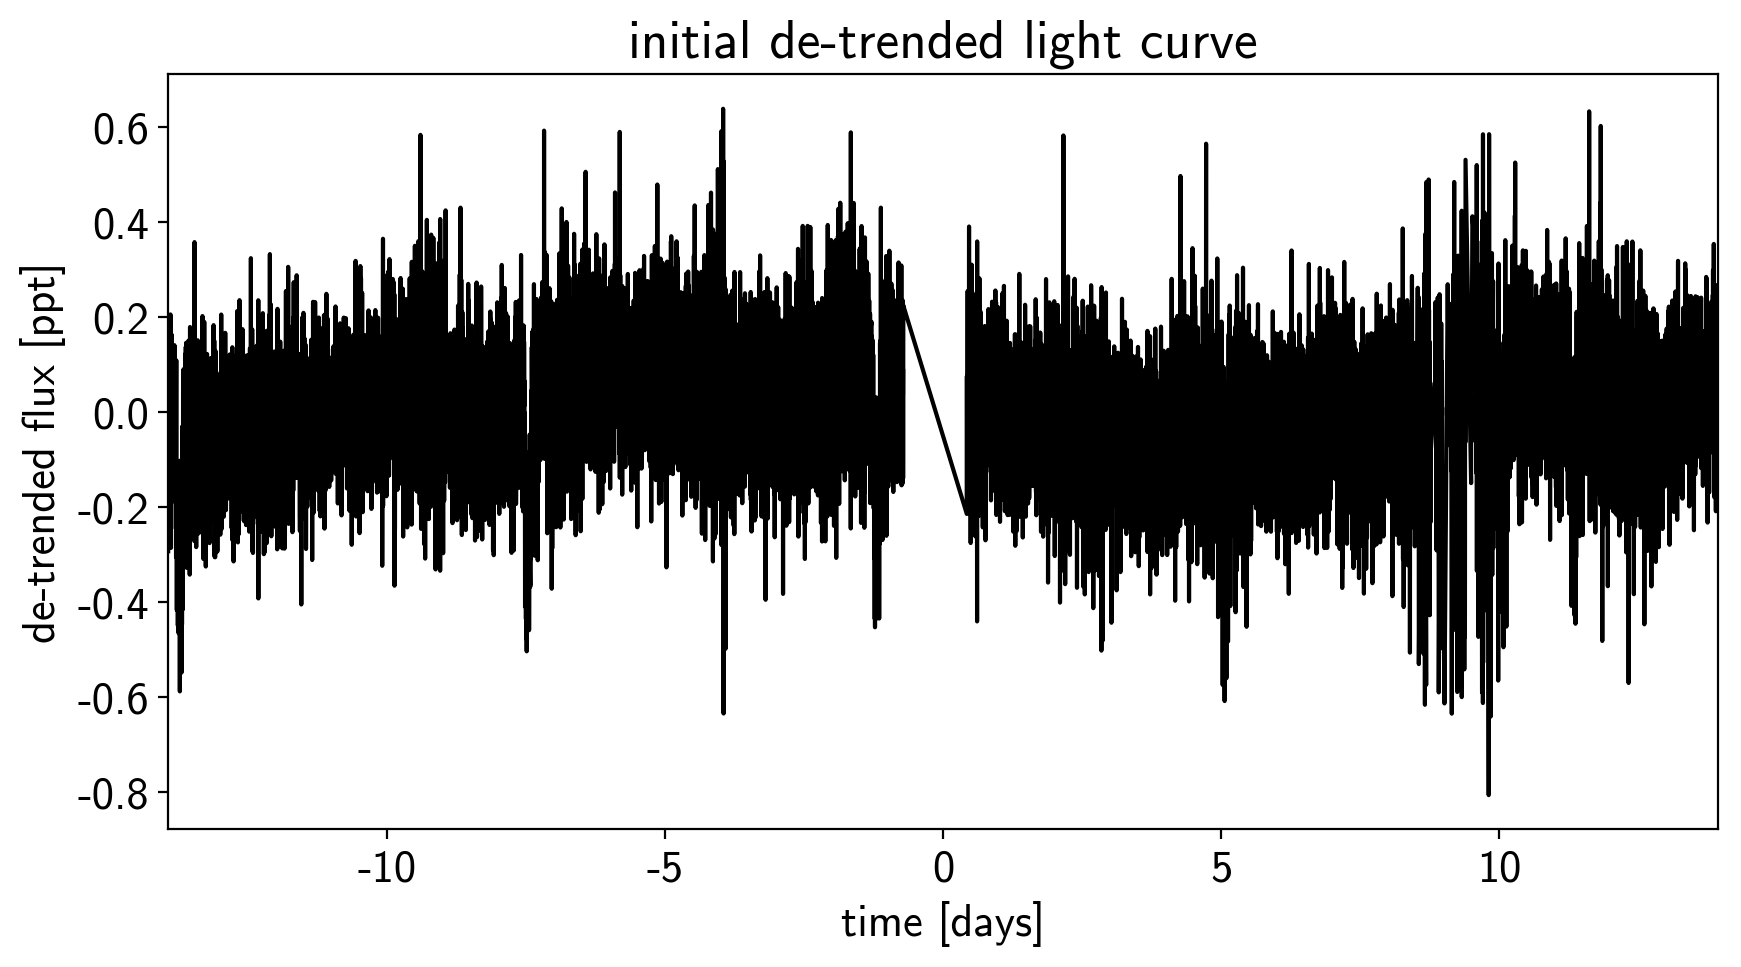

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

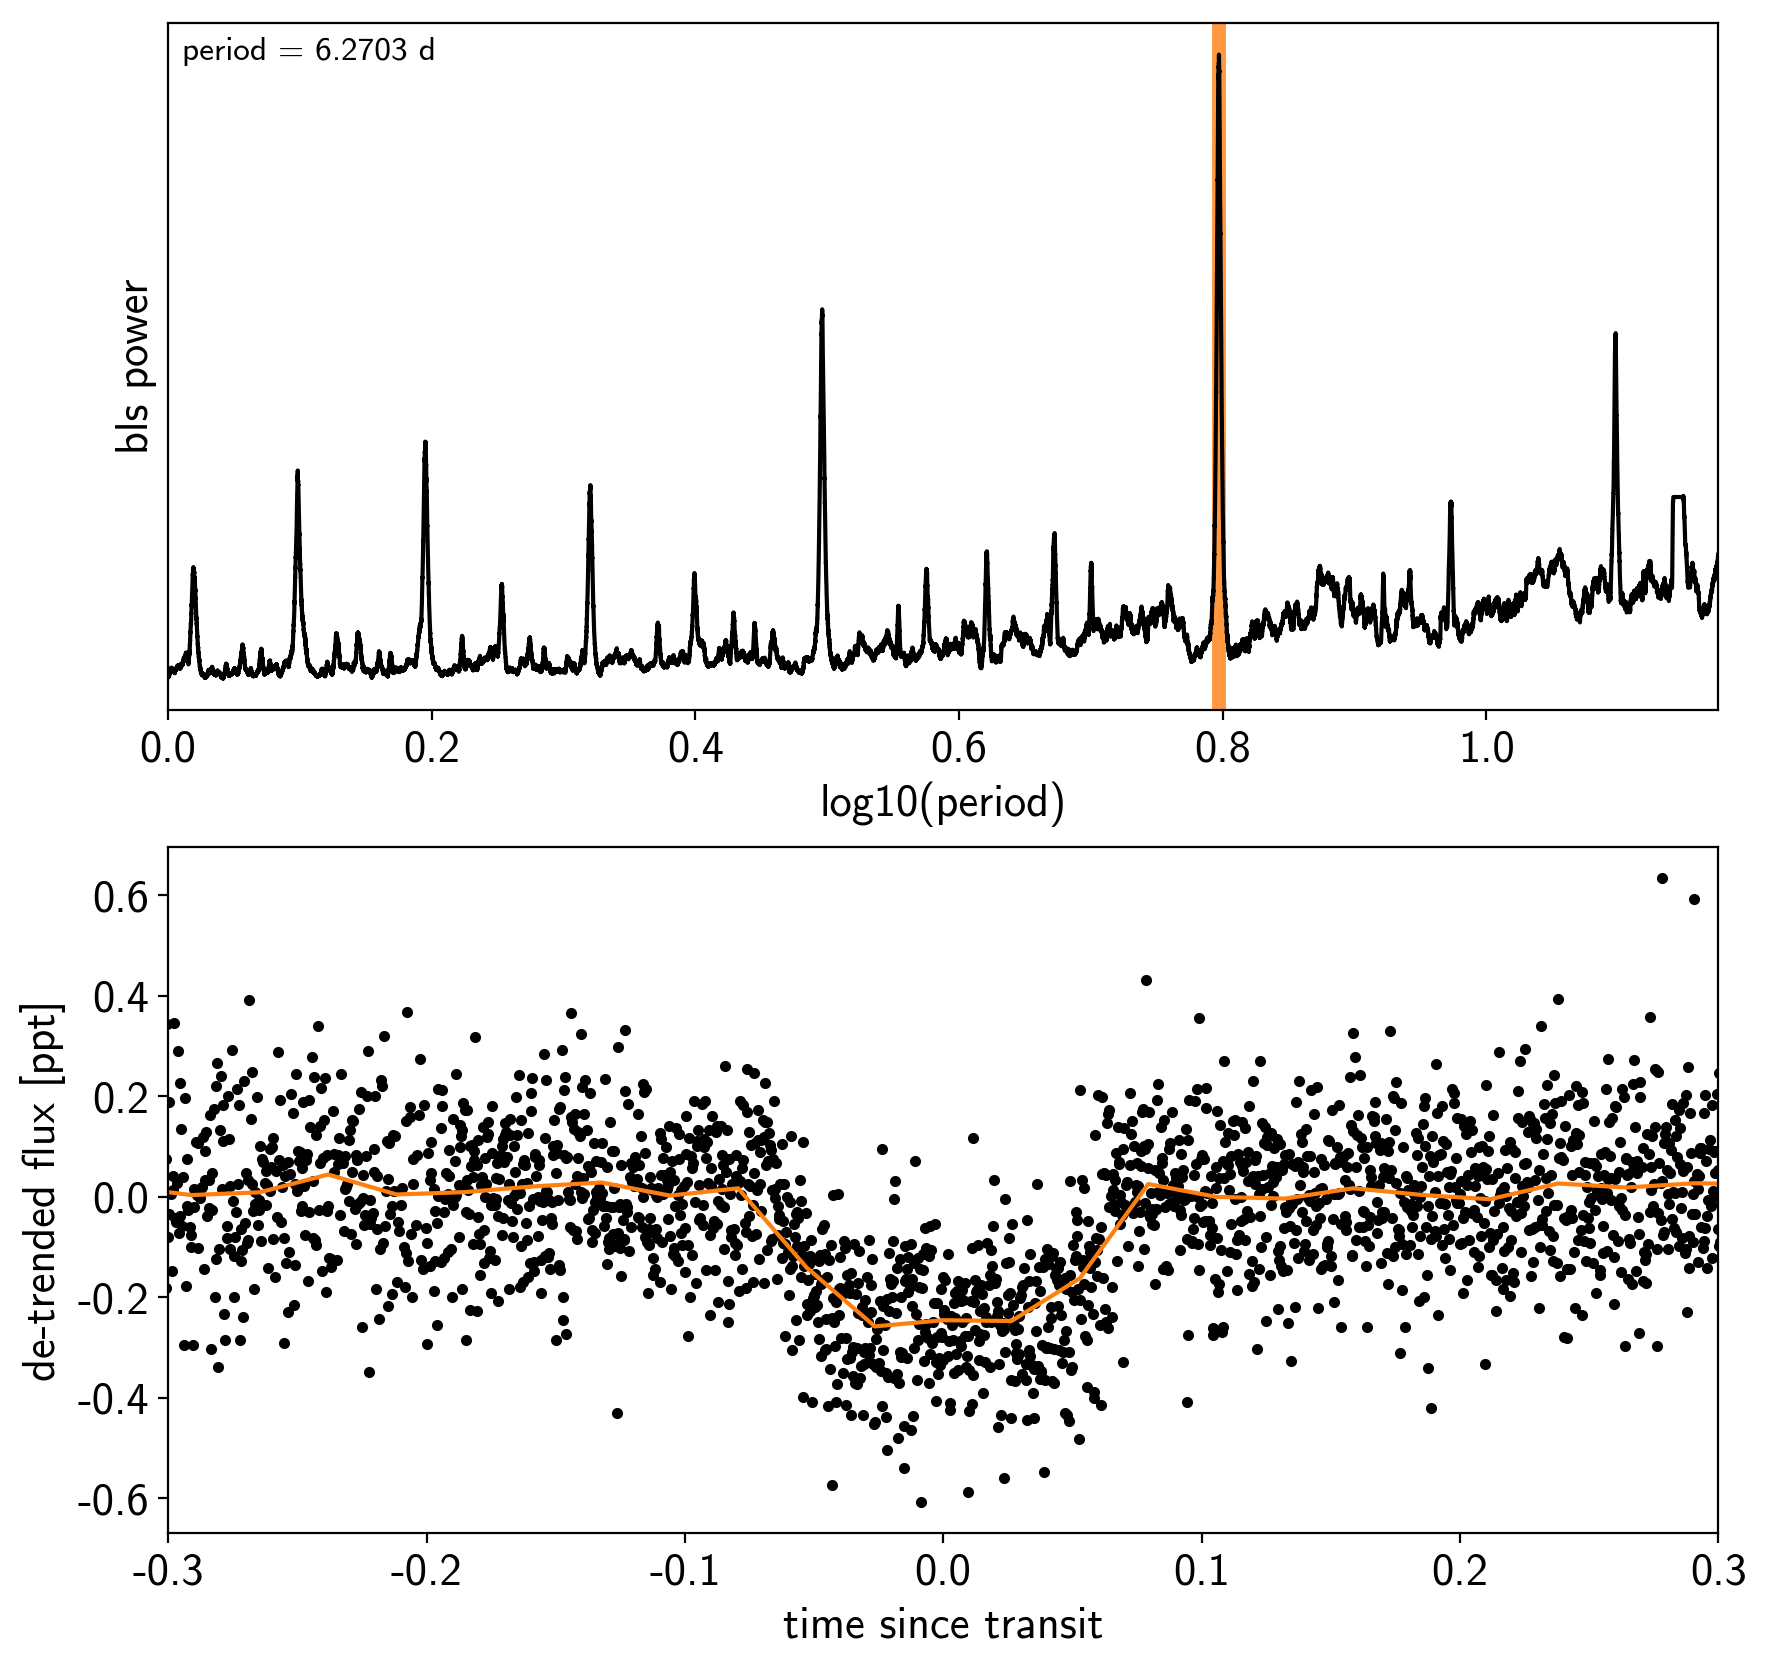

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

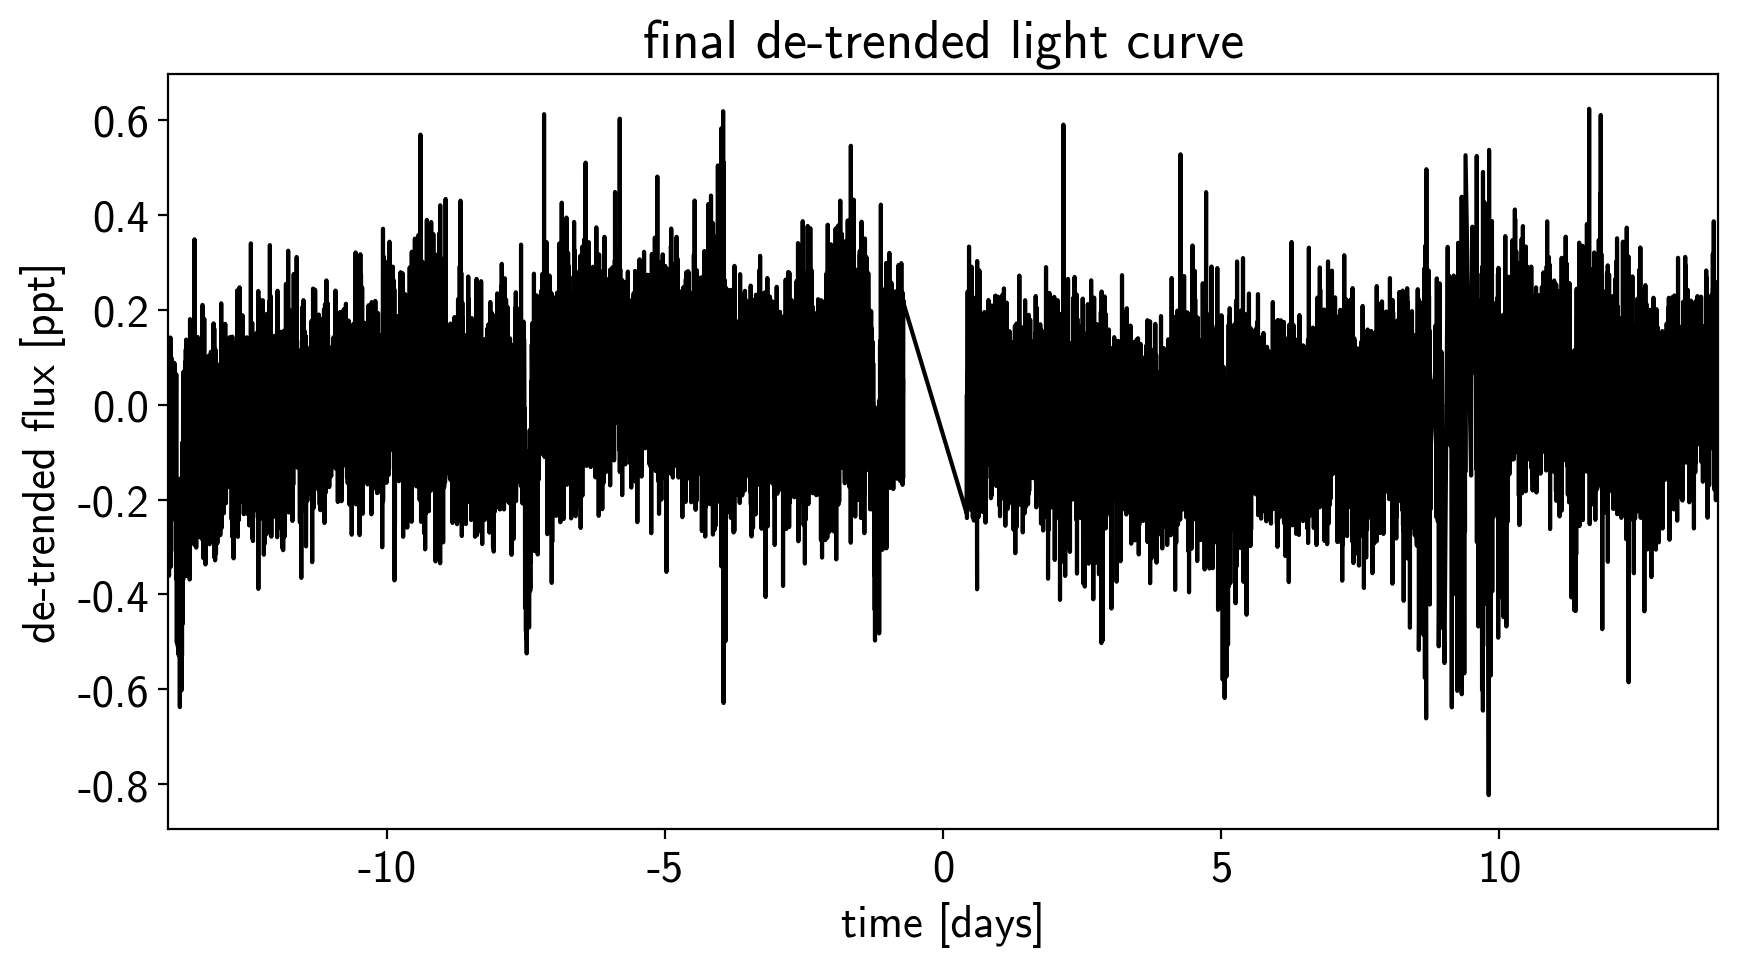

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [15]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        
    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline flux
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=0.5,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(model.y)), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower", mu=np.log(np.var(model.y)), sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        model.gp = xo.gp.GP(kernel, model.x, tt.exp(logs2)+model.yerr**2, J=2)
        pm.Potential("transit_obs", model.gp.log_likelihood(model.y - model.light_curve))
        model.gp_pred = model.gp.predict()

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.gp_pred + model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        print(ntot, mask.sum())
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

In [16]:
periods = [bls_period]
t0s = [bls_t0]
depths = [bls_depth]

yerr = np.median(np.abs(np.diff(y))) + np.zeros_like(x)
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

optimizing logp for variables: ['mean', 'logs2']
message: Optimization terminated successfully.
logp: 11104.734694544106 -> 12979.706195021747
optimizing logp for variables: ['mean', 'rb_radiusimpact__']
message: Optimization terminated successfully.
logp: 12979.706195021736 -> 12984.077966221928
optimizing logp for variables: ['mean', 't0', 'logP']
message: Optimization terminated successfully.
logp: 12984.077966221928 -> 12996.388808247171
optimizing logp for variables: ['logpower', 'logs2']
message: Optimization terminated successfully.
logp: 12996.388808247164 -> 12998.545230154612
optimizing logp for variables: ['logw0']
message: Optimization terminated successfully.
logp: 12998.545230154612 -> 13018.028552437587
optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: 13018.028552437601 -> 13031.96928314377
18054 17957
optimizing logp fo

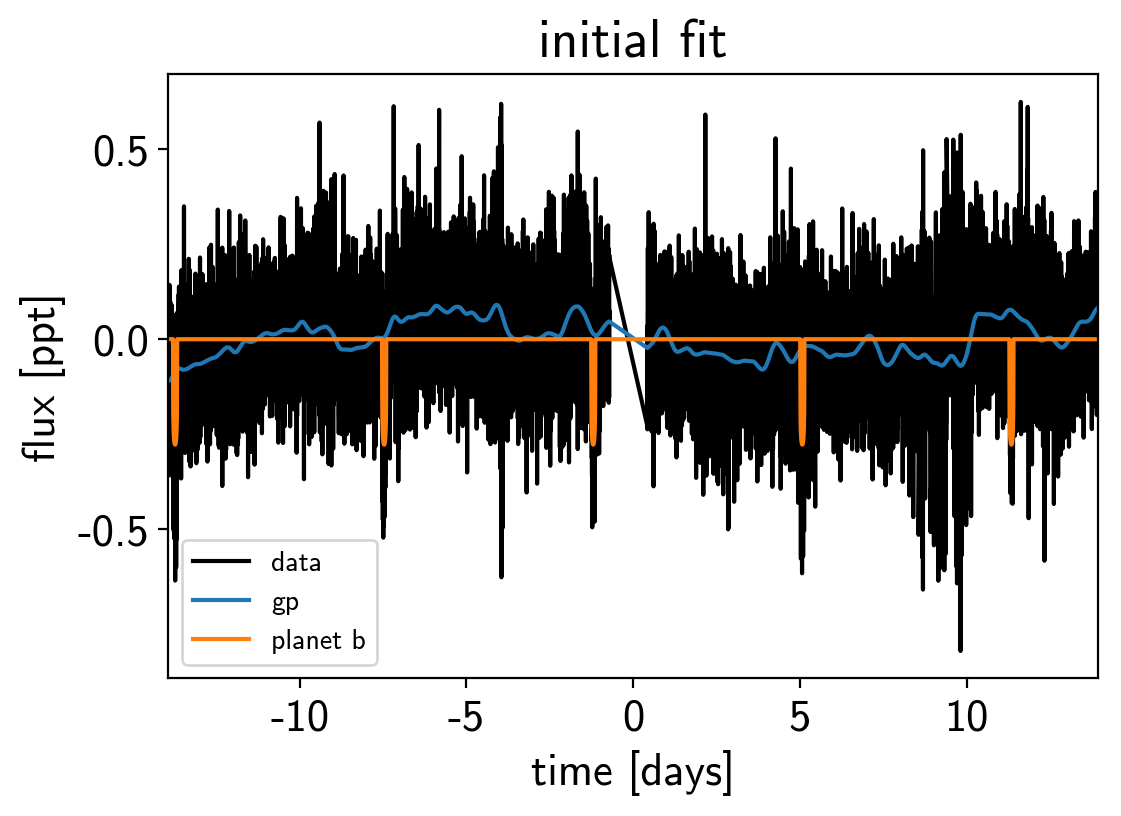

In [27]:
with model:
    mean = model.map_soln["mean"]
    gp_pred = xo.utils.eval_in_model(model.gp_pred, model.map_soln)
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
plt.plot(model.x, gp_pred, label="gp")
for n, l in enumerate("bcdefghijklmnopqrstuvwxyz"[:len(periods)]):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l))

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

In [33]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2)

Sampling 2 chains: 100%|██████████| 1004/1004 [00:41<00:00, 24.40draws/s]


In [34]:
with model:
    trace = sampler.sample(draws=1000, chains=2)

Sampling 2 chains: 100%|██████████| 2000/2000 [01:08<00:00, 29.37draws/s]


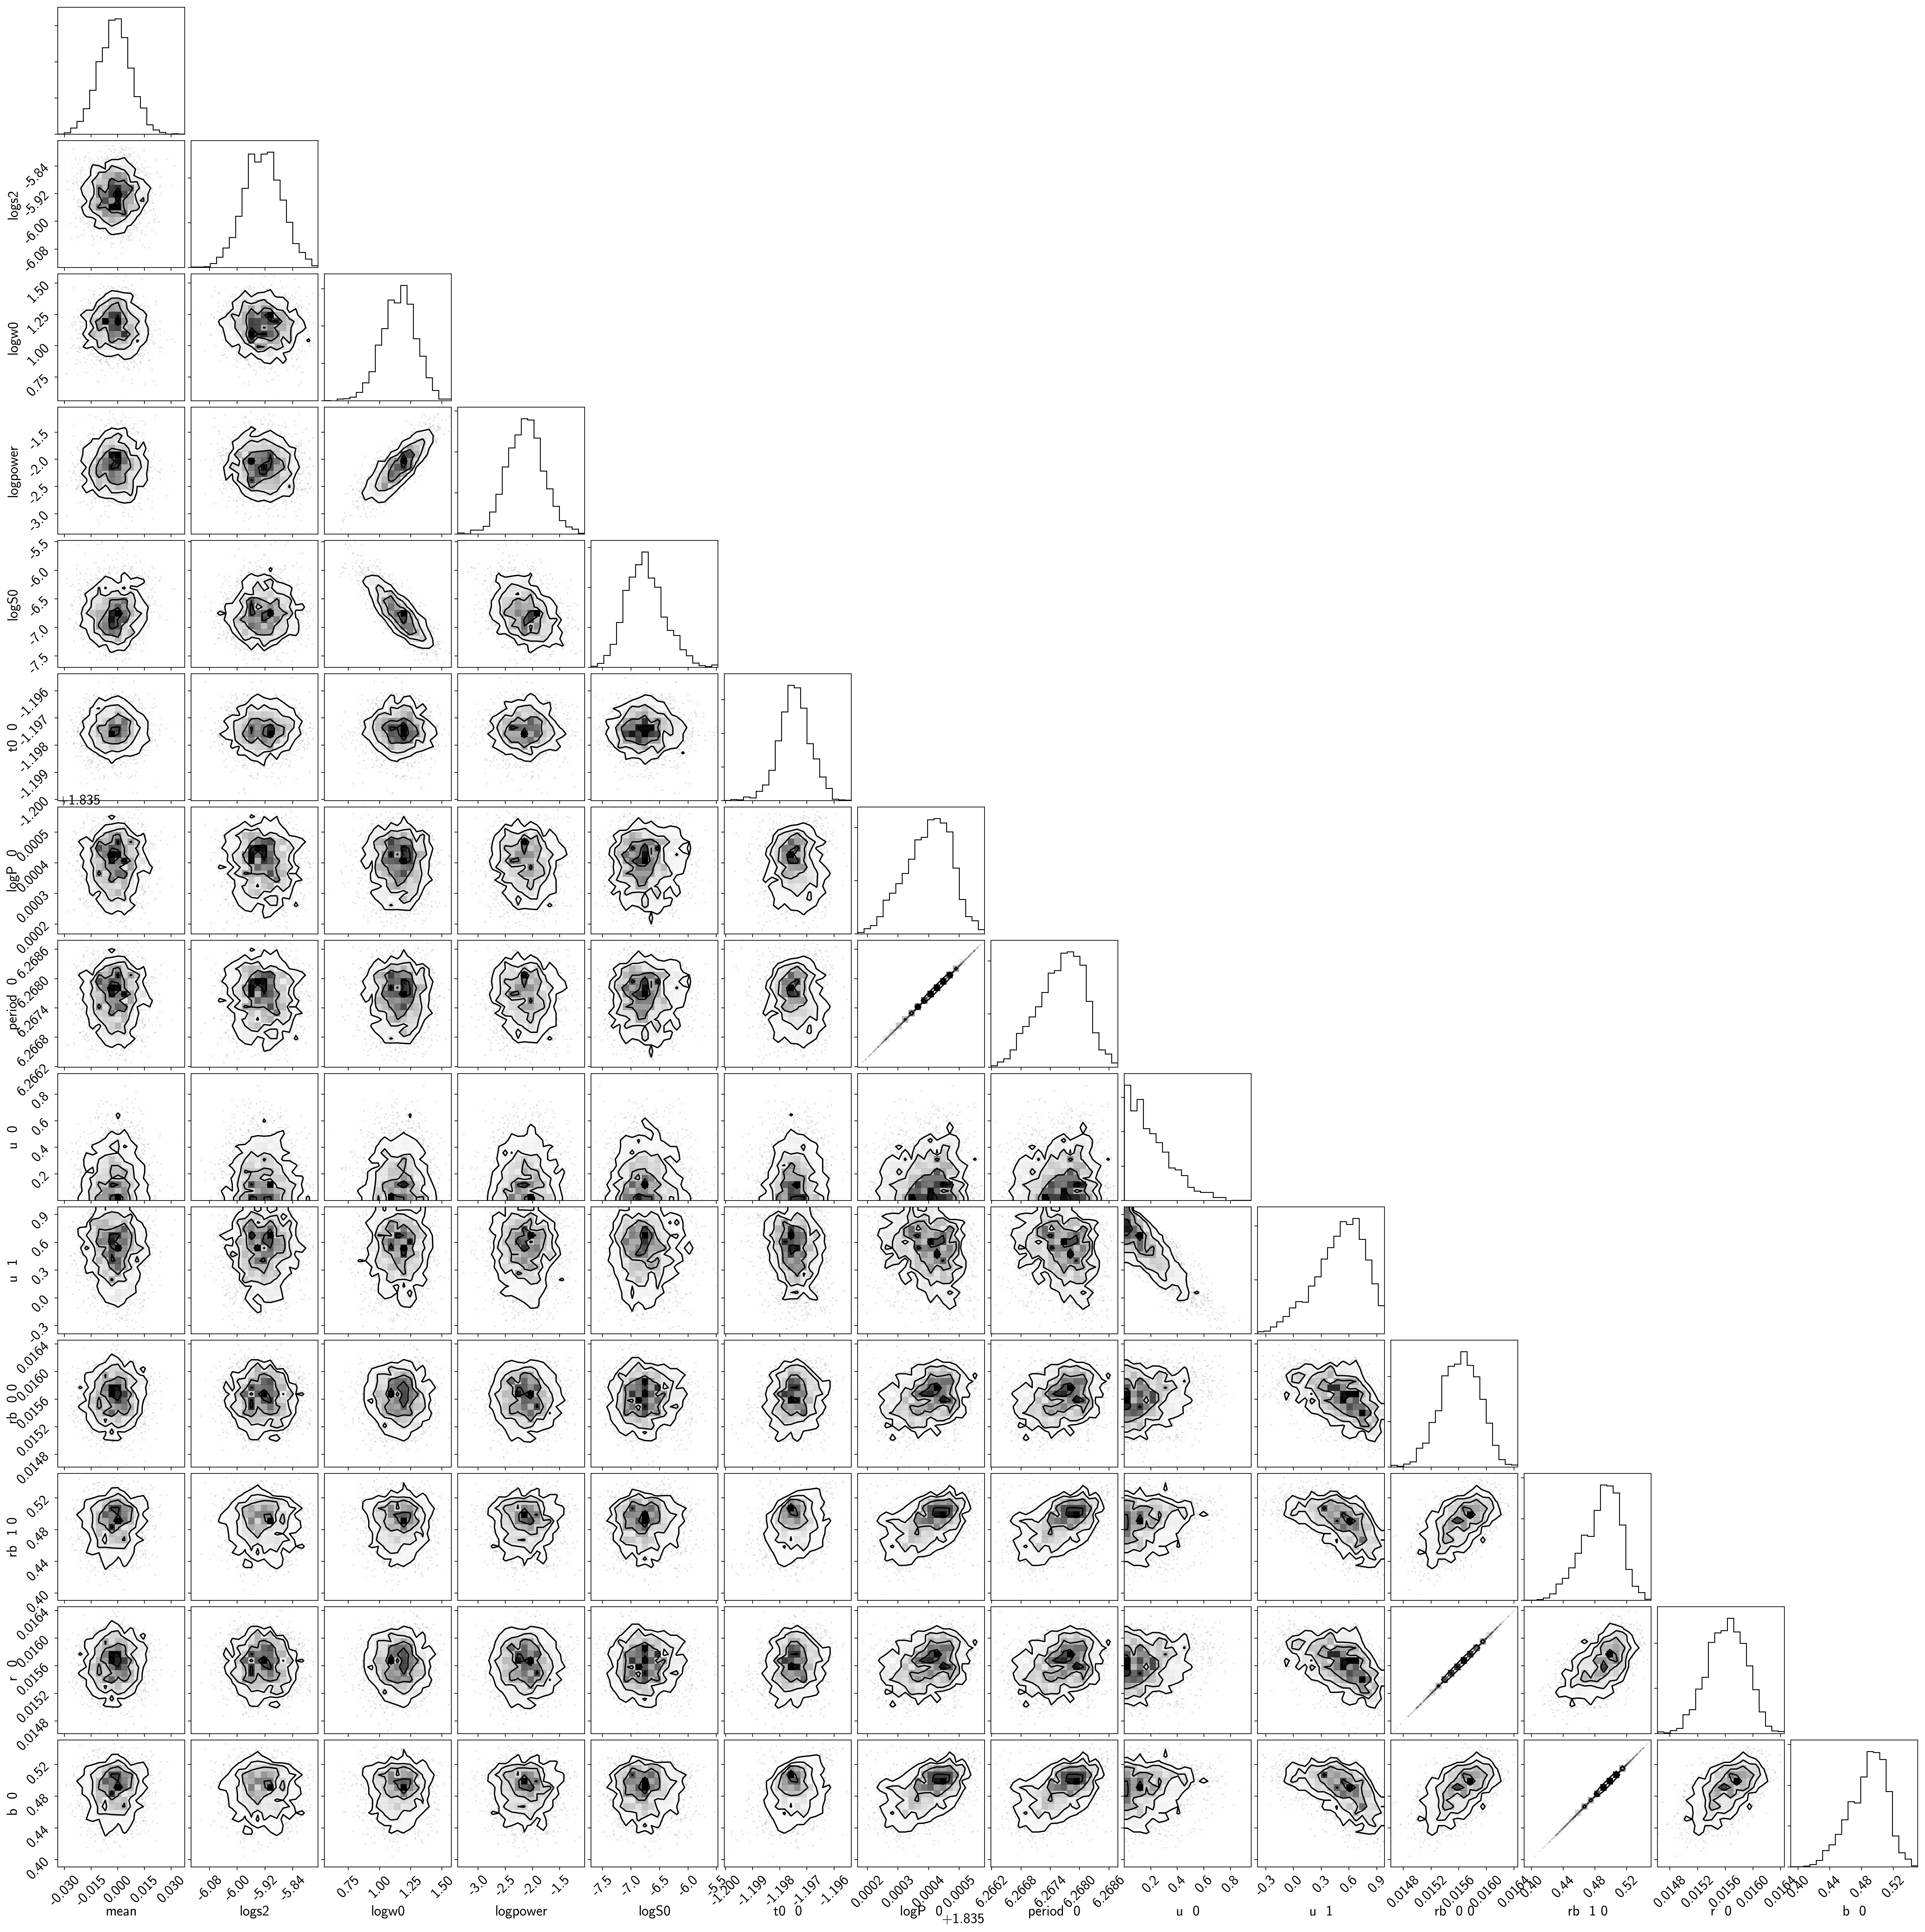

In [38]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=model.)
for name in samples.columns:
    if "_" in name:
        samples[name.replace("_", " ")] = samples[name]
        del samples[name]

corner.corner(samples);

In [40]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
mean      -0.001772  0.009190  0.000211 -0.019736  0.016120  1863.689348   
t0__0     -1.197458  0.000586  0.000014 -1.198583 -1.196265  1613.500992   
logP__0    1.835397  0.000075  0.000003  1.835246  1.835530   837.118494   
logs2     -5.926592  0.054440  0.001258 -6.026079 -5.812748  1969.505064   
logw0      1.153007  0.138268  0.003133  0.882223  1.421137  1861.775376   
logpower  -2.131389  0.333390  0.007317 -2.776219 -1.488178  2049.197281   
period__0  6.267623  0.000467  0.000016  6.266677  6.268457   837.130321   
u__0       0.205463  0.161409  0.003400  0.000170  0.523572  1908.459642   
u__1       0.495856  0.267047  0.006677 -0.034758  0.953541  1345.629355   
rb__0_0    0.015619  0.000282  0.000008  0.015091  0.016169  1413.372807   
rb__1_0    0.488090  0.023702  0.000758  0.437704  0.529551   801.089592   
r__0       0.015619  0.000282  0.000008  0.015091  0.016169  1413.372807   
b__0       0.488090  0.023702  0.000758  0.437704  0.529551   801.089592   
logS0     -6.743418  0.339108  0.008003 -7.379805 -6.064382  1838.583038   

               Rhat  
mean       0.999840  
t0__0      1.000208  
logP__0    1.000372  
logs2      0.999521  
logw0      0.999522  
logpower   0.999510  
period__0  1.000371  
u__0       0.999565  
u__1       0.999600  
rb__0_0    0.999572  
rb__1_0    0.999502  
r__0       0.999572  
b__0       0.999502  
logS0      0.999618